In [ ]:
# Generate randomly values of A and B and the expected result 

import numpy as np

# Convert a float16 into a binary string IEEE 754 (16 bits)
def float_to_bin16(f):
    return format(np.float16(f).view(np.uint16), '016b')

# Generate randomly a couple (A, B) in float 16
def generate_safe_random_vectors(num_elements=16, seed=5896
                                 ):  # change seed = change values of A and B and the expected result
    np.random.seed(seed)

    # Data of float16 without overflow/underflow
    min_val = -10.0
    max_val = 10.0

    a_vals = np.random.uniform(min_val, max_val, num_elements).astype(np.float16)
    b_vals = np.random.uniform(min_val, max_val, num_elements).astype(np.float16)

    inputs_a = [float_to_bin16(a) for a in a_vals]
    inputs_b = [float_to_bin16(b) for b in b_vals]

    # Accumulation
    accumulator = np.float16(0.0)
    for a, b in zip(a_vals, b_vals):
        product = np.float16(a * b)
        accumulator = np.float16(accumulator + product)

    expected_result = float_to_bin16(accumulator)

    return inputs_a, inputs_b, expected_result, a_vals, b_vals, accumulator

# Exporte constants to a file VHDL
def export_testbench(inputs_a, inputs_b, expected_result, filename="tb_mac_random_float16.vhd"):
    with open(filename, "w") as f:
        f.write("-- Testbench float16 random pseudonym without NaN/Inf/overflow/underflow\n")
        f.write("library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\n\n")
        f.write(f"constant NUM_CYCLES : integer := {len(inputs_a)};\n")
        f.write("type float_array is array (0 to NUM_CYCLES-1) of std_logic_vector(15 downto 0);\n\n")

        def write_array(name, data):
            f.write(f"constant {name} : float_array := (\n")
            for i, val in enumerate(data):
                f.write(f'    "{val}"')
                if i < len(data) - 1:
                    f.write(",\n")
                else:
                    f.write("\n")
            f.write(");\n\n")

        write_array("input_A", inputs_a)
        write_array("input_B", inputs_b)
        f.write(f'constant expected_result : std_logic_vector(15 downto 0) := "{expected_result}";\n')

# Point d’entrée
if __name__ == "__main__":
    A, B, result, a_vals, b_vals, acc = generate_safe_random_vectors()
    print("Inputs A (float16):", a_vals)
    print("Inputs B (float16):", b_vals)
    print("Expected Result (float16):", acc)
    print("Expected Result (bin):", result)
    export_testbench(A, B, result)




Inputs A (float16): [-0.07404  9.71     3.764    6.72    -4.02    -0.568    5.21     8.625
  2.773   -0.09015 -8.38     5.05     4.6      0.2595   3.969    1.188  ]
Inputs B (float16): [-6.59   9.13   8.54   2.625  1.708 -3.127 -5.29  -2.992  2.666 -7.246
 -6.793 -9.18  -8.86   3.266  2.832 -0.677]
Expected Result (float16): 69.6
Expected Result (bin): 0101010001011010


In [25]:
# Convert hex to float 16

def decode_float16_custom(hex_value):
    # Convert hex to 16-bit binary string
    bin_str = bin(int(hex_value, 16))[2:].zfill(16)

    sign = int(bin_str[0], 2)
    exponent = int(bin_str[1:6], 2)
    mantissa = int(bin_str[6:], 2)

    bias = 15  # 2^(5-1)-1

    if exponent == 0:
        # subnormal number
        value = ((-1) ** sign) * (mantissa / 2**10) * 2 ** (1 - bias)
    elif exponent == 31:
        # Inf or NaN
        value = float('inf') if mantissa == 0 else float('nan')
    else:
        # normalized number
        value = ((-1) ** sign) * (1 + mantissa / 2**10) * 2 ** (exponent - bias)

    return value

val1 = decode_float16_custom('4887')
val2 = decode_float16_custom('4701')

print(f"Value for 5895 (hex): {val1}")
print(f"Value for 5A7E (hex): {val2}")


Value for 5895 (hex): 9.0546875
Value for 5A7E (hex): 7.00390625


In [6]:
# Convert a list of binary number into a list of hexadecimal number

def bin_list_to_hex_list(bin_list):
    hex_list = []
    for b in bin_list:
        # Convertir la chaîne binaire en entier
        val_int = int(b, 2)
        # Convertir en hex avec le format '0x....' et en minuscules
        val_hex = hex(val_int)
        hex_list.append(val_hex)
    return hex_list

# Exemple d'utilisation
bin_list = [
"1101001101001110",
"1101001111100111",
"0011100011001110",
"1100110110010110",
"0100111001111100",
"1101000100110000",
"1100011110011011",
"0011101110111011",
"0101000101001111",
"0101000000011000",
"1101010101110001",
"0100011001001100",
"1011101011010010",
"0100011101010010",
"0011111111101000",
"0100000010101110"
]

hex_list = bin_list_to_hex_list(bin_list)
print(hex_list)


['0xd34e', '0xd3e7', '0x38ce', '0xcd96', '0x4e7c', '0xd130', '0xc79b', '0x3bbb', '0x514f', '0x5018', '0xd571', '0x464c', '0xbad2', '0x4752', '0x3fe8', '0x40ae']


In [5]:
# float16 * float16 operation 

import numpy as np

def hex_to_float16(h):
    # Convert hexadecimal string to float16 using uint16 as intermediary
    uint_val = np.uint16(int(h, 16))
    return uint_val.view(np.float16)

def float16_to_hex(f):
    # Convert float16 to hexadecimal string
    uint_val = f.view(np.uint16)
    return hex(uint_val)

def float16_to_bin(f):
    # Convert float16 to a 16-bit binary string
    uint_val = f.view(np.uint16)
    return format(uint_val, '016b')

def multiply_hex_float16_lists(h1_list, h2_list):
    # Multiply pairs of float16 values given as hex strings
    results_float16 = []
    results_hex = []
    results_bin = []
    for h1, h2 in zip(h1_list, h2_list):
        f1 = hex_to_float16(h1)
        f2 = hex_to_float16(h2)
        result = np.float16(f1 * f2)
        results_float16.append(result)
        results_hex.append(float16_to_hex(result))
        results_bin.append(float16_to_bin(result))
    return results_float16, results_hex, results_bin

# Input lists of float16 numbers in hexadecimal format
#h1_list = ['0xacbd', '0x48db', '0x4387', '0x46b8', '0xc405', '0xb88b', '0x4536', '0x4850', '0x418c', '0xadc5', '0xc831', '0x450d', '0x449a', '0x3427', '0x43f0', '0x3cc1']

#h2_list = ['0xc697', '0x4891', '0x4845', '0x4140', '0x3ed5', '0xc241', '0xc54a', '0xc1fc', '0x4155', '0xc73f', '0xc6cb', '0xc897', '0xc86e', '0x4288', '0x41aa', '0xb96a']

h1_list = ['0x5018', '0xc744', '0x4419', '0xc8e0', '0xc25f', '0xc5ed', '0x3dab', '0x3b4f', '0x48dc', '0xc29a', '0x48ab', '0x45ca', '0x3d15', '0xbbb1', '0x4072', '0xc1c9']
h2_list = ['0xd7b2', '0x485a', '0x30b1', '0x4095', '0xc812', '0x4701', '0xc55e', '0x3c3b', '0x445f', '0xc8f6', '0xc8aa', '0x3c5a', '0xb95e', '0xc79d', '0x3b1d', '0xba78']
# Perform multiplication
results_float16, results_hex, results_bin = multiply_hex_float16_lists(h1_list, h2_list)

# Display results
for i, (f16, hx, b) in enumerate(zip(results_float16, results_hex, results_bin)):
    print(f"Result {i+1} : float16 = {f16}, hex = {hx}, bin = {b}")

# Export binary results to a text file with required formatting
with open("resultats_binaires.txt", "w") as f:
    for i, b in enumerate(results_bin):
        if i != len(results_bin) - 1:
            f.write(f"\"{b}\",\n")
        else:
            f.write(f"\"{b}\"\n")

print("\n File 'resultats_binaires.txt' created with correct formatting.")




Result 1 : float16 = -4032.0, hex = 0xebe0, bin = 1110101111100000
Result 2 : float16 = -63.21875, hex = 0xd3e7, bin = 1101001111100111
Result 3 : float16 = 0.6005859375, hex = 0x38ce, bin = 0011100011001110
Result 4 : float16 = -22.34375, hex = 0xcd96, bin = 1100110110010110
Result 5 : float16 = 25.9375, hex = 0x4e7c, bin = 0100111001111100
Result 6 : float16 = -41.5, hex = 0xd130, bin = 1101000100110000
Result 7 : float16 = -7.60546875, hex = 0xc79b, bin = 1100011110011011
Result 8 : float16 = 0.96630859375, hex = 0x3bbb, bin = 0011101110111011
Result 9 : float16 = 42.46875, hex = 0x514f, bin = 0101000101001111
Result 10 : float16 = 32.75, hex = 0x5018, bin = 0101000000011000
Result 11 : float16 = -87.0625, hex = 0xd571, bin = 1101010101110001
Result 12 : float16 = 6.296875, hex = 0x464c, bin = 0100011001001100
Result 13 : float16 = -0.8525390625, hex = 0xbad2, bin = 1011101011010010
Result 14 : float16 = 7.3203125, hex = 0x4752, bin = 0100011101010010
Result 15 : float16 = 1.9765625

In [1]:
# float16 + float16 operation

import numpy as np

def hex_to_float16(h):
    uint_val = np.uint16(int(h, 16))
    return uint_val.view(np.float16)

def float16_to_hex(f):
    uint_val = f.view(np.uint16)
    return hex(uint_val)

def add_hex_float16_lists(h1_list, h2_list):
    results_float16 = []
    results_hex = []
    # On parcourt les deux listes en parallèle
    for h1, h2 in zip(h1_list, h2_list):
        f1 = hex_to_float16(h1)
        f2 = hex_to_float16(h2) #558b + c697
        result = np.float16(f1 + f2)
        results_float16.append(result)
        results_hex.append(float16_to_hex(result))
    return results_float16, results_hex

# Exemple d'utilisation avec des listes
h1_list = ['0x40e0', '0xd3e7', '0x38ce', '0xcd96', '0x4e7c', '0xd130', '0xc79b', '0x3bbb', '0x514f', '0x5018', '0xd571', '0x464c', '0xbad2', '0x4752', '0x3fe8', '0x40ae']
h2_list = ['0x4698', '0xd34e', '0xd79a', '0xd790', '0xd87b', '0xd757', '0xd8f8', '0xd935', '0xd92d', '0xd7b2', '0xd5a6', '0xd98c', '0xd95a', '0xd961', '0xd926', '0xd916']

#h1_list = ['0x37ce', '0x558b', '0x5004', '0x4c69', '0xc6de', '0x3f1a', '0xcee4', '0xce74', '0x4765', '0x393a', '0x531e', '0xd1cc', '0xd119', '0x3ac8', '0x499f', '0xba6f']
#h2_list = ['0x0000', '0x37ce', '0x5593', '0x5795','0x5858', '0x5821', '0x582f','0x56a5','0x5508', '0x557e', '0x5588', '0x588c','0x5632', '0x534b', '0x5366', '0x5467']

results_float16, results_hex = add_hex_float16_lists(h1_list, h2_list)

for i, (f16, hx) in enumerate(zip(results_float16, results_hex)):
    print(f"Résultat {i+1} : float16 = {f16}, hex = {hx}")



Résultat 1 : float16 = 9.03125, hex = 0x4884
Résultat 2 : float16 = -121.625, hex = 0xd79a
Résultat 3 : float16 = -121.0, hex = 0xd790
Résultat 4 : float16 = -143.375, hex = 0xd87b
Résultat 5 : float16 = -117.4375, hex = 0xd757
Résultat 6 : float16 = -159.0, hex = 0xd8f8
Résultat 7 : float16 = -166.625, hex = 0xd935
Résultat 8 : float16 = -165.625, hex = 0xd92d
Résultat 9 : float16 = -123.125, hex = 0xd7b2
Résultat 10 : float16 = -90.375, hex = 0xd5a6
Résultat 11 : float16 = -177.5, hex = 0xd98c
Résultat 12 : float16 = -171.25, hex = 0xd95a
Résultat 13 : float16 = -172.125, hex = 0xd961
Résultat 14 : float16 = -164.75, hex = 0xd926
Résultat 15 : float16 = -162.75, hex = 0xd916
Résultat 16 : float16 = -160.375, hex = 0xd903


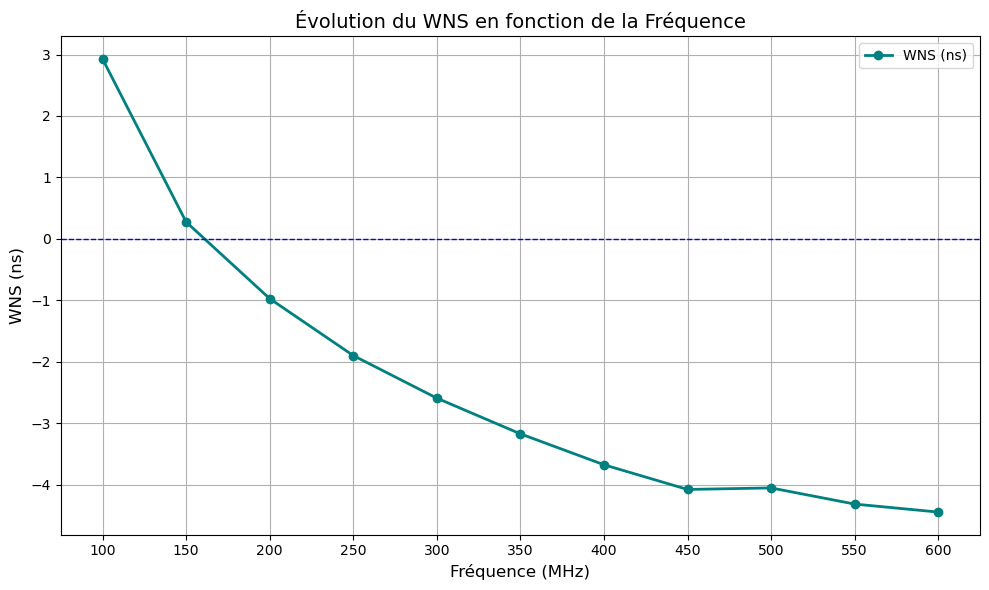

In [15]:
import matplotlib.pyplot as plt

# Données
frequency = [600, 550, 500, 450, 400, 350, 300, 250, 200, 150, 100]
wns = [-4.446, -4.316, -4.053, -4.078, -3.676, -3.173, -2.592, -1.899, -0.973, 0.275, 2.927]

plt.figure(figsize=(10, 6))
plt.plot(frequency, wns, color='teal', marker='o', linewidth=2, label='WNS (ns)')

plt.title("Évolution du WNS en fonction de la Fréquence", fontsize=14)
plt.xlabel("Fréquence (MHz)", fontsize=12)
plt.ylabel("WNS (ns)", fontsize=12)

plt.axhline(0, color='blue', linestyle='--', linewidth=1)

plt.xticks(sorted(frequency))  # Trie les ticks pour 100 → 600
plt.grid(True)
plt.legend()
# plt.gca().invert_xaxis()  # ⛔ Supprimé

plt.tight_layout()
plt.show()


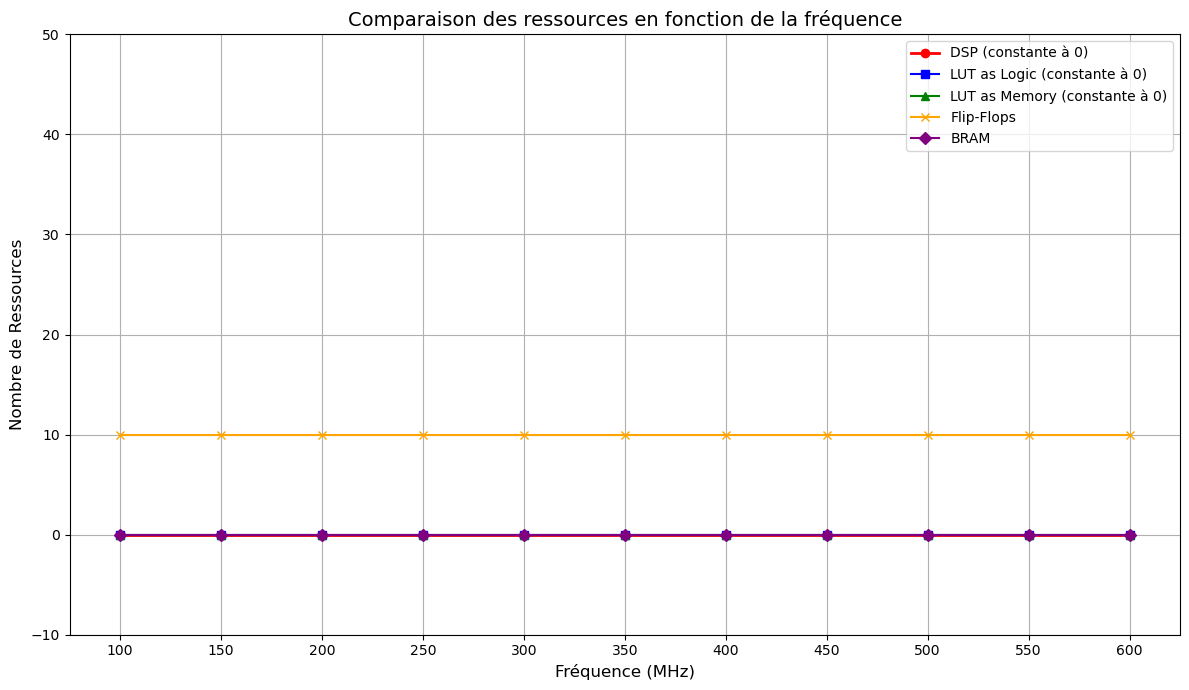

In [26]:
import matplotlib.pyplot as plt

# Données
frequency = [600, 550, 500, 450, 400, 350, 300, 250, 200, 150, 100]
dsp = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lut_as_logic = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lut_as_memory = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
flipflops = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
bram = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Tracé
plt.figure(figsize=(12, 7))

plt.plot(frequency, dsp, label='DSP (constante à 0)', color='red', marker='o', linewidth=2)
plt.plot(frequency, lut_as_logic, label='LUT as Logic (constante à 0)', color='blue', marker='s')
plt.plot(frequency, lut_as_memory, label='LUT as Memory (constante à 0)', color='green', marker='^')
plt.plot(frequency, flipflops, label='Flip-Flops', color='orange', marker='x')
plt.plot(frequency, bram, label='BRAM', color='purple', marker='D')

plt.title("Comparaison des ressources en fonction de la fréquence", fontsize=14)
plt.xlabel("Fréquence (MHz)", fontsize=12)
plt.ylabel("Nombre de Ressources", fontsize=12)

plt.legend()
plt.grid(True)
plt.xticks(sorted(frequency))  # Trie pour afficher de 100 à 600 MHz
# plt.gca().invert_xaxis()  # ⛔ Supprimé pour garder l'ordre croissant

plt.ylim(-10, max(lut_as_logic) + 50)
plt.tight_layout()
plt.show()


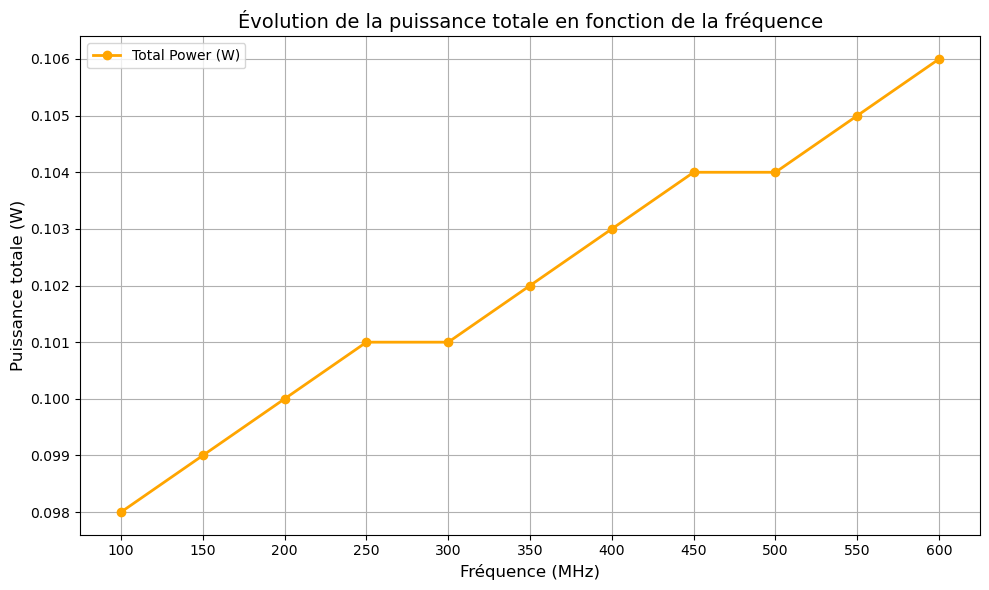

In [27]:
import matplotlib.pyplot as plt

# Données
frequency = [600, 550, 500, 450, 400, 350, 300, 250, 200, 150, 100]
total_power = [0.106, 0.105, 0.104, 0.104, 0.103, 0.102, 0.101, 0.101, 0.100, 0.099, 0.098]

plt.figure(figsize=(10, 6))
plt.plot(frequency, total_power, color='orange', marker='o', linewidth=2, label='Total Power (W)')

plt.title("Évolution de la puissance totale en fonction de la fréquence", fontsize=14)
plt.xlabel("Fréquence (MHz)", fontsize=12)
plt.ylabel("Puissance totale (W)", fontsize=12)

plt.xticks(sorted(frequency))  # Tri des ticks pour une meilleure lecture
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
